In [1]:
# Miminizzazione del sistema  V_n(𝐱) · σ(𝐱) = rhs(𝐱) dove  𝐱 = (a, b) ∈ [0,1]x[0,1] con un metodo di ottimizzazione ibrido (classico-quantistico)

from funzioni import solve_ab,Matrici_aerodinamiche,read_airfoil_file
import numpy as np
import sympy as sp
import math
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from skopt import gp_minimize
from skopt.space import Real
import matplotlib.pyplot as plt

In [ ]:
# Definizione della funzione di costo 

# amplitude encoding di un vettore ∈ ℝ^N : 
# x = (x0, ..., xN-1) -> |φ⟩ = (x0 * 1/||x||) |0⟩ + (x1 * 1/||x||) |1⟩ + ... + (xN-1 * 1/||x||) |N-1⟩ + 0 * |N⟩ + ... + 0 * |2^n - 1⟩
def amplitude_encoding(vettore) : 
    N = len(vettore)
    n = math.ceil(math.log2(N))
    norma = (sum([x**2 for x in vettore]))**(1/2)
    vettore.extend([0] * (2**n - N))
    state = [x/norma for x in vettore]
    return state

def cost(sigma_0, x, rhs, vn_ext) : 

    # Creazione del circuito quantistico per stimare la funzione di costo usando lo Swap Test  
    # il circuito è costituito da 2*n+1 qubit ( un registro di 1 qubit, un secondo e un terzo di n qubit ciascuno ) e 1 bit classico per la misura
    N = len(sigma_0) 
    n = math.ceil(math.log2(N))
    qc = QuantumCircuit(2*n+1,1)
    # inizializzazione del secondo registro allo stato quantistico corrispondente a sigma_0
    sigma_0 = amplitude_encoding(sigma_0) # amplitude encoding di sigma_0 
    qc.initialize(sigma_0,range(1,n+1))
    #inizializzazione del terzo registro allo stato quantistico corrispondente a sigma
    sigma = solve_ab(x[0], x[1], vn_ext, rhs)
    print(sigma)
    print(type(sigma))
    sigma = sigma.flatten().tolist() # da 'np.ndarray' a 'list'
    print(sigma)
    print(type(sigma))
    sigma = amplitude_encoding(sigma) # amplitude encoding di sigma 
    print(sigma)
    print(type(sigma))
    qc.initialize(sigma,range(n+1,2*n+1))
    # aggiunta di un gate di Hadamard sul primo qubit
    qc.h(0)
    # Swap Test tra il secondo e il terzo registro di qubit
    for i in range(1,n+1) : 
        qc.cswap(0,i,i+n) 
    # aggiunta di un gate di Hadamard sul primo qubit
    qc.h(0) 
    # aggiunta di un gate di misura sul primo qubit
    qc.measure(0,0) # la misura è memorizzata nel primo (e unico) bit classico

    # Definizione di un simulatore di un computer quantistico per l'esecuzione di qc 
    simulator = AerSimulator(method='statevector')
    num_shots = 2000
    result = simulator.run(qc, shots=num_shots).result() 
    counts = result.get_counts() 

    # funzione di costo : C(q_0) = 2 − (2/num_shots)* num_measure_0) dove num_measure_0 è il numero di volte in cui il qubit q_0 è misurato in |0⟩
    num_measure_0 = counts['0'] 
    cost_x = 2 -(2.0/num_shots)*(num_measure_0) 

    return cost_x

In [ ]:
# Dati iniziali del problema aerodinamico

data = read_airfoil_file("naca0012_07_sym.txt")
alpha_deg = 4
alpha_sym = sp.Float(np.deg2rad(alpha_deg))  # angolo simbolico ( in radianti per compatibilità con numpy )
vn_ext, rhs = Matrici_aerodinamiche(data, alpha_sym)  # V_n(𝐱) e rhs sono rispettivamente una matrice simbolica 9x9 e un vettore di dimensione 9 in funzione di 𝐱 = (a, b) ∈ [0,1]x[0,1]

In [ ]:
# Minimizzazione della funzione di costo 

# Parametri iniziali
sigma_0 = [0.7815136080484366, 0.8702848948594854, 1.333594725296618, 1.656720020972868, 0.5612358696279389, -0.2357639965490963, -0.7068146733682219, -1.059680396687932, 0.1033718030071634] # vettore target per la funzione di costo
cost_history = []

# Funzione ausiliaria per gli input di gp_minimize
def wrapper(x_k):
    cost_k = cost(sigma_0, x_k, rhs, vn_ext)
    cost_history.append(cost_k) 
    return cost_k

result = gp_minimize(func = wrapper, dimensions = [Real(0.0001,1,name = 'x0' ),Real(0.0001,1,name = 'x1' )], n_calls = 100,n_initial_points = 10,acq_func = 'EI',random_state=42,verbose=True)
print(f"punto di minimo : {result.x}, minimo : {result.fun}:")

Iteration No: 1 started. Evaluating function at random point.
[[-0.09633769]
 [-6.78418136]
 [ 6.39431884]
 [ 2.462306  ]
 [ 2.41124846]
 [ 6.7539609 ]
 [-7.29329606]
 [-0.81242143]
 [ 0.07216111]]
<class 'numpy.ndarray'>
[-0.09633769388681325, -6.784181362937559, 6.3943188381616265, 2.46230599588346, 2.4112484590614436, 6.753960896278102, -7.2932960620771, -0.8124214332374645, 0.072161114533609]
<class 'list'>
[-0.006841721060098288, -0.48179974663779634, 0.4541124464888388, 0.17486832109802142, 0.1712423112688641, 0.47965354617515155, -0.5179561109701315, -0.057696635711318674, 0.0051247460584307805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'list'>
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.6439
Function value obtained: 0.9560
Current minimum: 0.9560
Iteration No: 2 started. Evaluating function at random point.
[[-2.04329901]
 [-3.70075486]
 [ 3.81508208]
 [ 2.02437102]
 [ 1.81627658]
 [ 3.92138519]
 [-4.07919512]
 [-2.34192501]
 [ 0.04291854]]
<class 'num

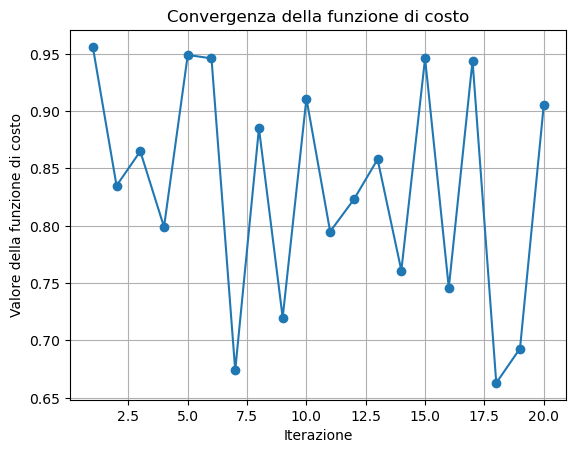

In [ ]:
# Plot della cost_history nel corso delle iterazioni

plt.plot(range(1, len(cost_history)+1), cost_history, marker='o')
plt.xlabel('Iterazione')
plt.ylabel('Valore della funzione di costo')
plt.title('Minimizzazione della funzione di costo')
plt.grid(True)
plt.show()

In [6]:
a_val = 0.5
b_val = 0.5
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))
a_val = 0.7
b_val = 0.2
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))
a_val = 2
b_val = 4
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))
a_val = 0.05
b_val = 0.07
print(cost(sigma_0, [a_val,b_val], rhs, vn_ext))

print('prova : ',cost(sigma_0, [0.05475272, 0.07565386], rhs, vn_ext))

 # Plots showing the convergence of the cost function over iterations

[[-1.46306881]
 [-0.69253312]
 [ 2.98013648]
 [ 1.65718148]
 [ 1.34577639]
 [ 3.02668308]
 [-1.03283607]
 [-1.80441084]
 [ 0.04973971]]
<class 'numpy.ndarray'>
[-1.4630688050341378, -0.6925331238411921, 2.9801364755815967, 1.6571814758927612, 1.3457763865140697, 3.0266830799696915, -1.0328360690100034, -1.804410844234139, 0.04973971408623942]
<class 'list'>
[-0.2691690227906334, -0.12740922610958746, 0.5482725215348323, 0.30488102604469525, 0.24759007478411088, 0.5568359629630524, -0.19001667894344523, -0.3319676436160447, 0.009150895835118416, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
<class 'list'>
0.782
[[-0.15397782]
 [-5.69026052]
 [ 5.345384  ]
 [ 2.15827226]
 [ 2.04538068]
 [ 5.65164692]
 [-6.18078821]
 [-0.8274981 ]
 [ 0.07090055]]
<class 'numpy.ndarray'>
[-0.1539778219533105, -5.690260519249417, 5.345384001010895, 2.1582722612024368, 2.0453806796069802, 5.6516469167626315, -6.180788207433203, -0.8274981017742533, 0.07090055003388147]
<class 'list'>
[-0.012983365500441463, -0.47980112